# Baseline Model - Rule-based Matching

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import pandas as pd

In [3]:
import sys
from pathlib import Path

# ensure repo root
%cd /content/drive/MyDrive/Final-Project-snapAddy/src

sys.path.append(str(Path.cwd()))

/content/drive/MyDrive/Final-Project-snapAddy/src


In [4]:
DATA_DIR = Path("/content/sample_data")
department_path = DATA_DIR / "department-v2.csv"
seniority_path = DATA_DIR / "seniority-v2.csv"

In [5]:
department_df = pd.read_csv("../data/raw/department-v2.csv")
seniority_df = pd.read_csv("../data/raw/seniority-v2.csv")
jobs_annotated_df = pd.read_csv("../data/processed/jobs_annotated.csv")

In [6]:
from utils.eval_utils import evaluate_predictions
from utils.results_utils import add_result, save_results

As the baseline, we implement a rule-based classifier that assigns department and seniority labels by matching job titles against the predefined label lists

the predefined label lists are:

- department_df
- seniority_df

**Rule logic**

Substring matching against predefined label lists is used for the rule-based baseline. Only minimal syntactic normalization is applied, while semantic transformations are deliberately avoided to preserve the baseline’s role as a simple, non-learning reference model.

In [7]:
department_df.head()

,text,label
0,Adjoint directeur communication,Marketing
1,Advisor Strategy and Projects,Project Management
2,Beratung & Projekte,Project Management
3,Beratung & Projektmanagement,Project Management
4,Beratung und Projektmanagement kommunale Partner,Project Management


In [8]:
seniority_df.head()

,text,label
0,Analyst,Junior
1,Analyste financier,Junior
2,Anwendungstechnischer Mitarbeiter,Junior
3,Application Engineer,Senior
4,Applications Engineer,Senior


In [9]:
jobs_annotated_df.head()

,cv_id,job_index,organization,position,startDate,endDate,status,department,seniority
0,0,0,Depot4Design GmbH,Prokurist,2019-08,NaN,ACTIVE,Other,Management
1,0,1,Depot4Design GmbH,CFO,2019-07,NaN,ACTIVE,Other,Management
2,0,2,Depot4Design GmbH,Betriebswirtin,2019-07,NaN,ACTIVE,Other,Professional
3,0,3,Depot4Design GmbH,Prokuristin,2019-07,NaN,ACTIVE,Other,Management
4,0,4,Depot4Design GmbH,CFO,2019-07,NaN,ACTIVE,Other,Management


## 1. Data Preparation

### 1.1 Normalization function

For rule-based matching, job titles and label-list entries are normalized using lowercasing and whitespace stripping before applying simple substring matching:

- lowercasing
- stripping whitespace and collapsing multiple internal spaces

This is done to avoid any accidental mismatching due to lower/uppercasing or spacing (spaces, tabs, line breaks).

We want to make sure the normalization does not alter meaning or generalize semantics, but simply removes formatting noise. Therefore, no further text processing is applied in order to keep the baseline fully interpretable. We apply the same normalization to CV titles and the label-list titles.

In [10]:
def normalize_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower().strip()
    text = " ".join(text.split())
    return text

The function is directly applied to the label lists and will be build into the rule-based prediction function for the dataset.

In [11]:
department_df["text_norm"] = department_df["text"].apply(normalize_text)
seniority_df["text_norm"] = seniority_df["text"].apply(normalize_text)

### 1.2 Prediction Functions

Our rule-based matching functions implement a rule-based classifier using the provided department and seniority label list where job titles are matched via substring rules. Unmatched titles to departments are assigned to the label ‘Other’. For seniority we explicitly use "Professional" as default for unmatched titles, because no label such as "Other" exists in seniority. Since this is the most frequent seniority class, it is used as the fallback label to avoid artificially inflating rare classes. “Professional” acts as a fallback class, since it is present in the CV annotations but not explicitly represented in the predefined seniority keyword list. Whenever no seniority-specific keyword is matched, the model defaults to “Professional”.

In [12]:
def predict_department_rule_based(title, department_df):
    title_norm = normalize_text(title)

    for _, row in department_df.iterrows():
        if row["text_norm"] in title_norm:
            return row["label"]

    return "Other"

In [13]:
def predict_seniority_rule_based(title, seniority_df):
    title_norm = normalize_text(title)

    for _, row in seniority_df.iterrows():
        if row["text_norm"] in title_norm:
            return row["label"]

    # Default fallback if nothing matches
    return "Professional"

## 2. Rule-based Matching
The rule-based matching baseline does not involve training and is therefore evaluated on the full dataset (in contrast all learning-based models will be evaluated out-of-sample using a fixed train–test split)

- x = current job only

We only look at the current job title to predict department and seniority. In the data "current job" means that the status is active. And the job is found in the column position. We have 2 y variables, one is department and the other one seniority. Furthermore, we add the cv_id as metadata to enable grouping, evaluation and error analysis at the CV level without being used as a model feature.

Furthermore, we only inlcude the jobs that have exactly 1 active job

In [14]:
rows = []

for cv_id, cv_df in jobs_annotated_df.groupby("cv_id"):
    active_jobs = cv_df[cv_df["status"] == "ACTIVE"]

    # Require exactly one active job
    if len(active_jobs) != 1:
      continue

    current = active_jobs.iloc[0]

    rows.append({
        "cv_id": cv_id,
        "text": current["position"],
        "department": current["department"],
        "seniority": current["seniority"],
    })

In [15]:
base = pd.DataFrame(rows)

In [16]:
X_base = base["text"]
y_dep_base = base["department"]
y_sen_base = base["seniority"]
meta_base = base["cv_id"]

In [17]:
X_base.head()

,text
0,Solutions Architect
1,Medizintechnik Beratung
2,"APL-ansvarig, samordning"
3,Kaufmännischer Leiter
4,Lab-Supervisor


In [18]:
y_sen_base.head()

,seniority
0,Professional
1,Professional
2,Lead
3,Lead
4,Lead


In [19]:
y_dep_base.head()

,department
0,Information Technology
1,Consulting
2,Administrative
3,Sales
4,Other


**Department Matching**

In [20]:
y_dep_pred_base = X_base.apply(
    lambda title: predict_department_rule_based(title, department_df)
)

In [21]:
metrics_dep_base = evaluate_predictions(y_dep_base, y_dep_pred_base)
metrics_dep_base

{'accuracy': 0.6026315789473684, 'macro_f1': 0.44918940911600075, 'mae': None}

**Seniority Matching**

In [22]:
y_sen_pred_base = X_base.apply(
    lambda title: predict_seniority_rule_based(title, seniority_df)
)

In [23]:
metrics_sen_base = evaluate_predictions(y_sen_base, y_sen_pred_base)
metrics_sen_base

{'accuracy': 0.5368421052631579, 'macro_f1': 0.42616200731397247, 'mae': None}

**Confusion Matrix**

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

<Figure size 2000x2000 with 0 Axes>

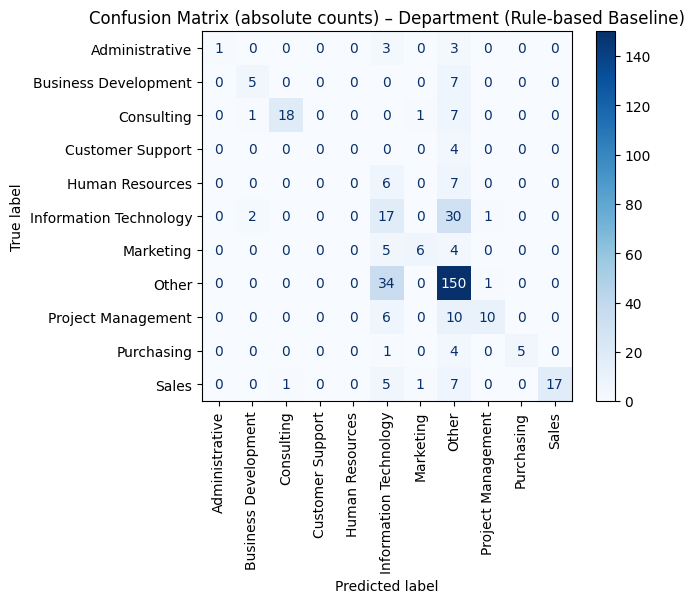

In [43]:
cm_dep = confusion_matrix(
    y_dep_base,
    y_dep_pred_base,
    labels=sorted(y_dep_base.unique())
)

disp_dep = ConfusionMatrixDisplay(
    confusion_matrix=cm_dep,
    display_labels=sorted(y_dep_base.unique())
)

plt.figure(figsize=(20, 20))
disp_dep.plot(
    cmap="Blues",
    xticks_rotation=90,
    values_format="d"
)
plt.title("Confusion Matrix (absolute counts) – Department (Rule-based Baseline)")
#plt.tight_layout()
plt.show()

The department confusion matrix reveals that the rule-based baseline strongly relies on explicit keywords and defaults to the “Other” category when no clear match is found. While domains such as Sales and Consulting are identified reasonably well, many roles from related or ambiguous departments are misclassified as “Other”, indicating limited contextual understanding.

<Figure size 800x800 with 0 Axes>

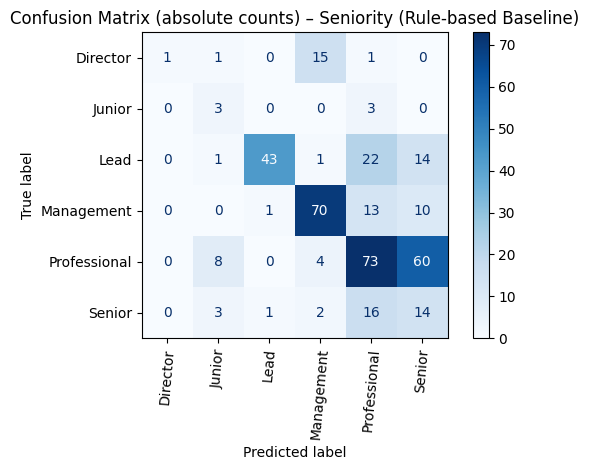

In [42]:
cm_sen = confusion_matrix(
    y_sen_base,
    y_sen_pred_base,
    labels=sorted(y_sen_base.unique())
)

disp_sen = ConfusionMatrixDisplay(
    confusion_matrix=cm_sen,
    display_labels=sorted(y_sen_base.unique())
)

plt.figure(figsize=(8, 8))
disp_sen.plot(
    cmap="Blues",
    xticks_rotation=85,
    values_format="d"
)
plt.title("Confusion Matrix (absolute counts) – Seniority (Rule-based Baseline)")
plt.tight_layout()
plt.show()

The seniority confusion matrix is strongly influenced by the role of “Professional” as a fallback class in the rule-based baseline. Since many job titles do not contain explicit seniority indicators, they are defaulted to “Professional”, leading to a high concentration of predictions in this class. While seniority levels with clear keywords (e.g. Lead or Management) are recognized reasonably well, substantial confusion arises for mid-level roles. This behavior highlights the limitations of keyword-based matching and motivates the use of context-aware machine learning models.

In [ ]:
def build_error_dfs(X, y_true, y_pred, meta=None, target_name="target", extension=False):
    df = pd.DataFrame(
        {
            "title": X.values,
            "true": pd.Series(y_true).values,
            "pred": pd.Series(y_pred).values,
        }
    )
    df["correct"] = df["true"].eq(df["pred"])
    df["extension"] = extension
    df["target"] = target_name

    if meta is not None:
        meta_df = meta.reset_index(drop=True).copy()
        df = pd.concat([meta_df, df.reset_index(drop=True)], axis=1)

    # per-class accuracy (where it's good/bad)
    by_true = (
        df.groupby(["target", "extension", "true"], dropna=False)["correct"]
        .agg(n="size", accuracy="mean")
        .reset_index()
        .sort_values(["target", "extension", "accuracy", "n"], ascending=[True, True, True, False])
    )

    # confusion pairs (where it's bad)
    confusion = (
        df.loc[~df["correct"]]
        .groupby(["target", "extension", "true", "pred"], dropna=False)
        .size()
        .reset_index(name="count")
        .sort_values(["target", "extension", "count"], ascending=[True, True, False])
    )

    # examples to inspect
    best_examples = df.loc[df["correct"]].head(50).copy()
    worst_examples = df.loc[~df["correct"]].head(50).copy()

    return df, by_true, confusion, best_examples, worst_examples


# Department
dep_base_df, dep_base_by_true, dep_base_conf, dep_base_best, dep_base_worst = build_error_dfs(
    X_base, y_dep_base, y_dep_pred_base, meta=meta_base, target_name="department", extension=False
)

# Seniority
sen_base_df, sen_base_by_true, sen_base_conf, sen_base_best, sen_base_worst = build_error_dfs(
    X_base, y_sen_base, y_sen_pred_base, meta=meta_base, target_name="seniority", extension=False
)

# One combined df if you want everything in one place
all_preds_df = pd.concat([dep_base_df, sen_base_df], ignore_index=True)

# Summaries (good vs bad areas)
all_by_true_df = pd.concat(
    [dep_base_by_true, sen_base_by_true], ignore_index=True
)
all_confusions_df = pd.concat(
    [dep_base_conf, sen_base_conf], ignore_index=True
)

display(all_by_true_df.head(50))
display(all_confusions_df.head(50))
display(all_preds_df.sample(50, random_state=0))

,target,extension,true,n,accuracy
0,department,False,Human Resources,13,0.000000
1,department,False,Customer Support,4,0.000000
2,department,False,Administrative,7,0.142857
3,department,False,Information Technology,50,0.340000
4,department,False,Project Management,26,0.384615
5,department,False,Marketing,15,0.400000
6,department,False,Business Development,12,0.416667
7,department,False,Purchasing,10,0.500000
8,department,False,Sales,31,0.548387
9,department,False,Consulting,27,0.666667


,target,extension,true,pred,count
0,department,False,Other,Information Technology,34
1,department,False,Information Technology,Other,30
2,department,False,Project Management,Other,10
3,department,False,Business Development,Other,7
4,department,False,Consulting,Other,7
5,department,False,Human Resources,Other,7
6,department,False,Sales,Other,7
7,department,False,Human Resources,Information Technology,6
8,department,False,Project Management,Information Technology,6
9,department,False,Marketing,Information Technology,5


,cv_id,title,true,pred,correct,extension,target
748,591,Supply Chain Manager,Professional,Senior,False,False,seniority
583,329,Senior Enterprise IT Systems Specialist,Senior,Professional,False,False,seniority
575,319,Owner,Management,Management,True,False,seniority
40,66,Technical Customer Service Manager - Flexible ...,Customer Support,Other,False,False,department
243,381,Senior Vice President,Other,Other,True,False,department
389,14,energy and sustainability consultant bei,Professional,Senior,False,False,seniority
428,77,Project Engineer Process Technology - Future F...,Professional,Senior,False,False,seniority
122,197,Responsable technique,Information Technology,Other,False,False,department
31,55,Projektleiterin Bildung,Other,Information Technology,False,False,department
283,449,PHD Student,Other,Other,True,False,department


In [ ]:
results = []

add_result(
    results,
    model_name="Rule-based",
    target="department",
    metrics=metrics_dep_base
)

add_result(
    results,
    model_name="Rule-based",
    target="seniority",
    metrics=metrics_sen_base
)

save_results(results)

In [ ]:
results_df_baseline = pd.DataFrame(results)
results_df_baseline

,model,target,accuracy,macro_f1,mae
0,Rule-based,department,0.602632,0.449189,None
1,Rule-based,seniority,0.536842,0.426162,None


In [ ]:
import os
print(os.getcwd())

/content/drive/MyDrive/Final-Project-snapAddy/src


In [ ]:
!ls ..

archive		       model-1-baseline.py
data		       model6_Bag_of_Words_TF–IDF_+_Logistic_Regression.ipynb
data_prep_eda.ipynb    results_comparison.ipynb
eda_seniorities.ipynb  src


In [ ]:
!ls ../data

all_results.csv  processed  raw  results
